## Семинар: "Методы оптимизации"

In [2]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


На этом семинаре мы попробуем реализовать и сравнить различные методы оптимизации: SGD, Momentum, NAG, Adagrad, RMSProp, AdaDelta.

### Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [3]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

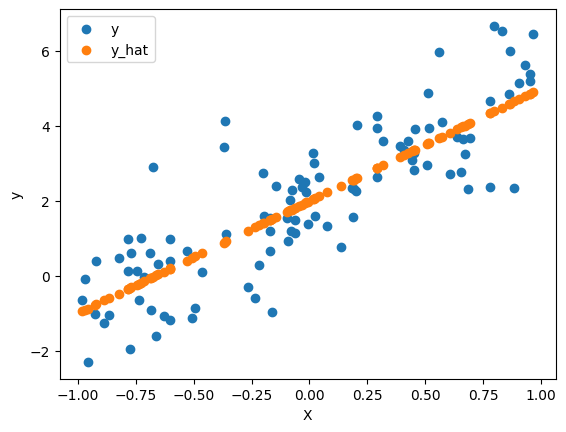

In [4]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

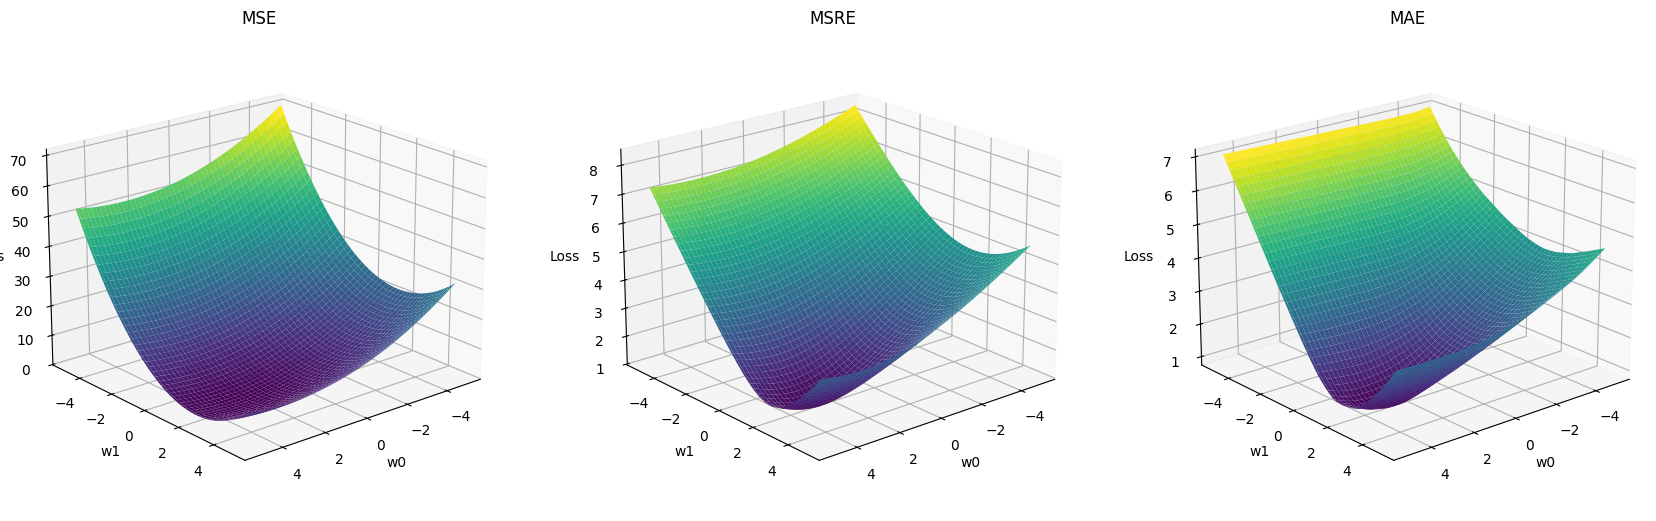

In [5]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [6]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [7]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [8]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

#### SGD
$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_{i} (\theta_{t-1})$$

In [9]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


#### Momentum
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [10]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= self.prev_momentum[i]

#### Nesterov Accelerated Gradient (NAG)
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1} - \gamma \nu_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [11]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

#### AdaGrad
$$G_t = \sum_{k=0}^t g_{k}^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [12]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.eta * p.grad / torch.sqrt(self.G[i] + self.epsilon)

#### RMSProp
$$G_t = \gamma G_{t-1} + (1 - \gamma) g_t^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [13]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [14]:
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)

In [15]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', NAG, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta' : 1}],
        ['RMSProp', RMSProp, {'eta' : 1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

100%|██████████| 5/5 [00:00<00:00, 27.14it/s]


###  Домашнее задание: Обучение нейронной сети + Подбор шага

В этом задании вам нужно:
1) Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW. **(2 балла)**
2) Реализовать LinearLR и CosineAnnealingLR. Обучить сверточную нейросеть на MNIST с SGD, Adam, AdamW с LinearLR, CosineAnnealingLR. Сравните графики изменения loss-функции и точности (суммарно должно быть 9 экспериментов, 3 из которых покрываются пунктом 1). **(3 балла)**

Ссылки:
- https://arxiv.org/abs/1711.05101 (AdamW, статья)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html (AdamW, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html (LinearLR, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html (CosineAnnealingLR, PyTorch)

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


tar: Error opening archive: Failed to open 'MNIST.tar.gz'


In [21]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [23]:
def train(model, optimizer, train_dataloader, val_dataloader, n_epochs=10, device="cpu", verbose=True, plot=True):
    criterion = nn.CrossEntropyLoss()

    train_loss_epochs = []
    val_loss_epochs = []
    train_accuracy_epochs = []
    val_accuracy_epochs = []

    model.to(device)

    try:
        for epoch in range(n_epochs):
            model.train()
            train_losses = []
            train_correct = 0
            total_train = 0

            for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{n_epochs} [Train]"):
                x_train, y_train = x_train.to(device), y_train.to(device)

                optimizer.zero_grad()
                y_pred = model(x_train)

                loss = criterion(y_pred, y_train)
                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())
                train_correct += (y_pred.argmax(dim=1) == y_train).sum().item()
                total_train += y_train.size(0)

            avg_train_loss = np.mean(train_losses)
            train_acc = train_correct / total_train

            train_loss_epochs.append(avg_train_loss)
            train_accuracy_epochs.append(train_acc)

            model.eval()
            val_losses = []
            val_correct = 0
            total_val = 0

            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{n_epochs} [Val]"):
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    y_pred = model(x_val)

                    loss = criterion(y_pred, y_val)
                    val_losses.append(loss.item())

                    val_correct += (y_pred.argmax(dim=1) == y_val).sum().item()
                    total_val += y_val.size(0)

            avg_val_loss = np.mean(val_losses)
            val_acc = val_correct / total_val

            val_loss_epochs.append(avg_val_loss)
            val_accuracy_epochs.append(val_acc)

            if verbose:
                print(f"Epoch {epoch+1}/{n_epochs} "
                      f"- Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} "
                      f"- Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if plot:
            plt.figure(figsize=(12,5))
            plt.subplot(1,2,1)
            plt.plot(train_loss_epochs, label="Train Loss")
            plt.plot(val_loss_epochs, label="Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid(True)

            plt.subplot(1,2,2)
            plt.plot(train_accuracy_epochs, label="Train Acc")
            plt.plot(val_accuracy_epochs, label="Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.grid(True)

            plt.show()

    except KeyboardInterrupt:
        print("Прервано пользователем.")

    return train_loss_epochs, val_loss_epochs, train_accuracy_epochs, val_accuracy_epochs


In [18]:
import os


def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer

    def step(self):
        pass

In [ ]:
class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        start_factor: float = 0.1,
        end_factor: float = 1.0,
        total_iters: int = 100
    ):
        super().__init__()
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters

    def step(self):
        pass

class CosineAnnealing(LRScheduler):
    def __init__(
            self,
            optimizer: Optimizer,
            T_max: int = 20,
            eta_min: float = 0.01
        ):
        super().__init__()
        self.T_max = T_max
        self.eta_min = eta_min

    def step(self):
        pass

#### Adam

Момент и затухание:

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

Коррекция смещения:

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \qquad 
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

Обновление весов:

$$
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \cdot \hat{m}_t
$$


In [16]:
class Adam(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9, beta1=0.9, beta2=0.999):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma
        self.beta1 = beta1
        self.beta2 = beta2

        self.m = [torch.zeros(p.shape) for p in self.params]
        self.v = [torch.zeros(p.shape) for p in self.params]
        self.t = 0


    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * p.grad * p.grad

                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)

                p -= self.eta * m_hat / (torch.sqrt(v_hat) + self.epsilon)

#### AdamW

Обновление моментов:

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$  

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$  

Коррекция смещения:

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, 
\quad 
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$  

---

Обновление весов с decoupled weight decay:

$$
\theta_{t+1} = \theta_t - \eta \cdot \lambda \cdot \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \cdot \hat{m}_t
$$  

In [17]:
class AdamW(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9, beta1=0.9, beta2=0.999, lambd=0.01):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma
        self.beta1 = beta1
        self.beta2 = beta2
        self.lambd = lambd

        self.m = [torch.zeros(p.shape) for p in self.params]
        self.v = [torch.zeros(p.shape) for p in self.params]
        self.t = 0


    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * p.grad * p.grad

                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)

                p -= self.eta * self.lambd * p

                p -= self.eta * m_hat / (torch.sqrt(v_hat) + self.epsilon)

In [25]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*20, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = Adam(model.parameters())

Epoch 1/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 140.78it/s]


Epoch 1/10 - Train Loss: 0.1597, Train Acc: 0.9530 - Val Loss: 0.1091, Val Acc: 0.9657


Epoch 2/10 [Val]: 100%|██████████| 313/313 [00:01<00:00, 163.46it/s]


Epoch 2/10 - Train Loss: 0.0977, Train Acc: 0.9728 - Val Loss: 0.1352, Val Acc: 0.9660


Epoch 3/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 146.90it/s]


Epoch 3/10 - Train Loss: 0.0939, Train Acc: 0.9756 - Val Loss: 0.1032, Val Acc: 0.9714


Epoch 4/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 147.68it/s]


Epoch 4/10 - Train Loss: 0.0907, Train Acc: 0.9768 - Val Loss: 0.1220, Val Acc: 0.9681


Epoch 5/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 143.39it/s]


Epoch 5/10 - Train Loss: 0.0829, Train Acc: 0.9799 - Val Loss: 0.0846, Val Acc: 0.9764


Epoch 6/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 140.23it/s]


Epoch 6/10 - Train Loss: 0.0826, Train Acc: 0.9798 - Val Loss: 0.1200, Val Acc: 0.9729


Epoch 7/10 [Val]: 100%|██████████| 313/313 [00:01<00:00, 170.30it/s]


Epoch 7/10 - Train Loss: 0.0847, Train Acc: 0.9804 - Val Loss: 0.1585, Val Acc: 0.9699


Epoch 8/10 [Val]: 100%|██████████| 313/313 [00:01<00:00, 161.98it/s]


Epoch 8/10 - Train Loss: 0.0800, Train Acc: 0.9817 - Val Loss: 0.1345, Val Acc: 0.9771


Epoch 9/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 144.48it/s]


Epoch 9/10 - Train Loss: 0.0918, Train Acc: 0.9806 - Val Loss: 0.1254, Val Acc: 0.9720


Epoch 10/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 124.73it/s]


Epoch 10/10 - Train Loss: 0.0743, Train Acc: 0.9837 - Val Loss: 0.1376, Val Acc: 0.9743


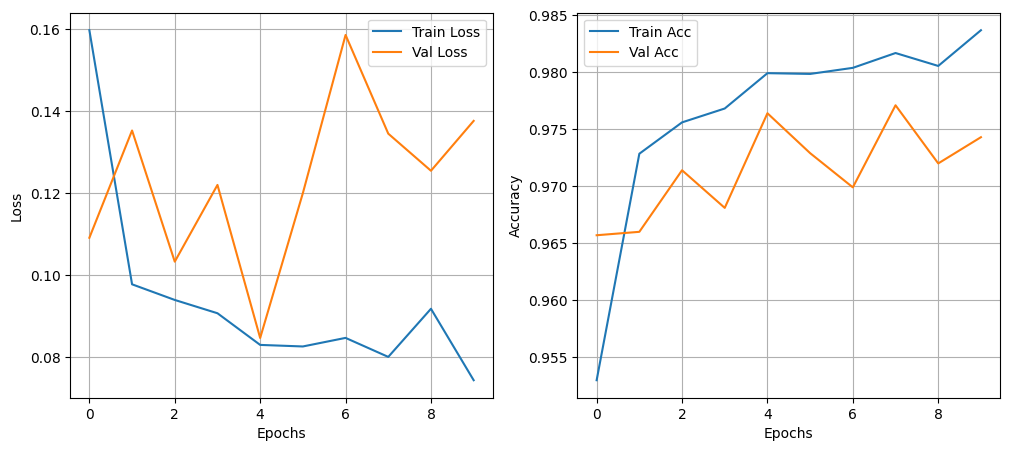

In [26]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(model, optimizer, train_loader, test_loader)

In [28]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(6*6*20, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1)
)
optimizer = AdamW(model.parameters())

Epoch 1/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 127.15it/s]


Epoch 1/10 - Train Loss: 0.1667, Train Acc: 0.9498 - Val Loss: 0.0815, Val Acc: 0.9756


Epoch 2/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 140.75it/s]


Epoch 2/10 - Train Loss: 0.0963, Train Acc: 0.9720 - Val Loss: 0.1024, Val Acc: 0.9689


Epoch 3/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 106.82it/s]


Epoch 3/10 - Train Loss: 0.0892, Train Acc: 0.9753 - Val Loss: 0.0845, Val Acc: 0.9757


Epoch 4/10 [Val]: 100%|██████████| 313/313 [00:01<00:00, 165.11it/s]


Epoch 4/10 - Train Loss: 0.0807, Train Acc: 0.9774 - Val Loss: 0.0751, Val Acc: 0.9790


Epoch 5/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 117.80it/s]


Epoch 5/10 - Train Loss: 0.0799, Train Acc: 0.9786 - Val Loss: 0.0874, Val Acc: 0.9761


Epoch 6/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 127.42it/s]


Epoch 6/10 - Train Loss: 0.0769, Train Acc: 0.9798 - Val Loss: 0.0936, Val Acc: 0.9762


Epoch 7/10 [Val]: 100%|██████████| 313/313 [00:01<00:00, 157.75it/s]


Epoch 7/10 - Train Loss: 0.0774, Train Acc: 0.9800 - Val Loss: 0.0728, Val Acc: 0.9809


Epoch 8/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 137.80it/s]


Epoch 8/10 - Train Loss: 0.0707, Train Acc: 0.9814 - Val Loss: 0.0704, Val Acc: 0.9815


Epoch 9/10 [Val]: 100%|██████████| 313/313 [00:01<00:00, 159.55it/s]


Epoch 9/10 - Train Loss: 0.0723, Train Acc: 0.9813 - Val Loss: 0.0748, Val Acc: 0.9815


Epoch 10/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 150.15it/s]


Epoch 10/10 - Train Loss: 0.0704, Train Acc: 0.9816 - Val Loss: 0.1137, Val Acc: 0.9751


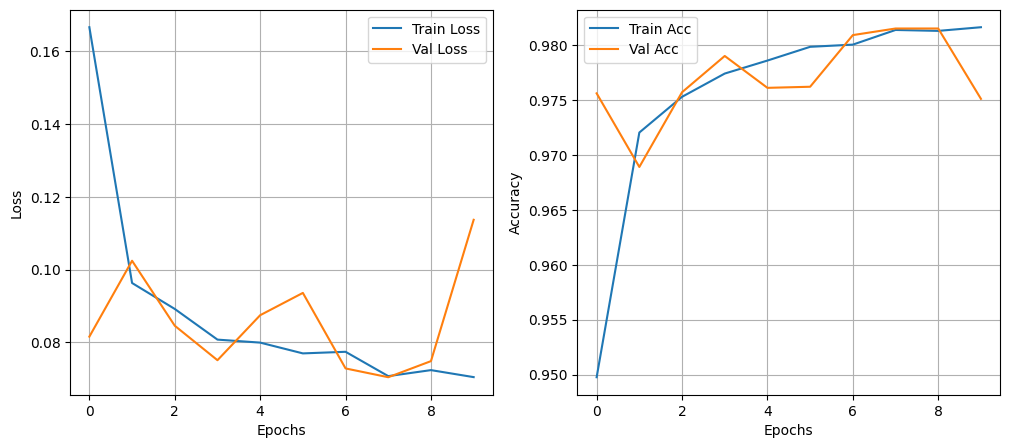

In [29]:
tr_w, ts_w, tr_ac_w, ts_ac_w = train(model, optimizer, train_loader, test_loader)

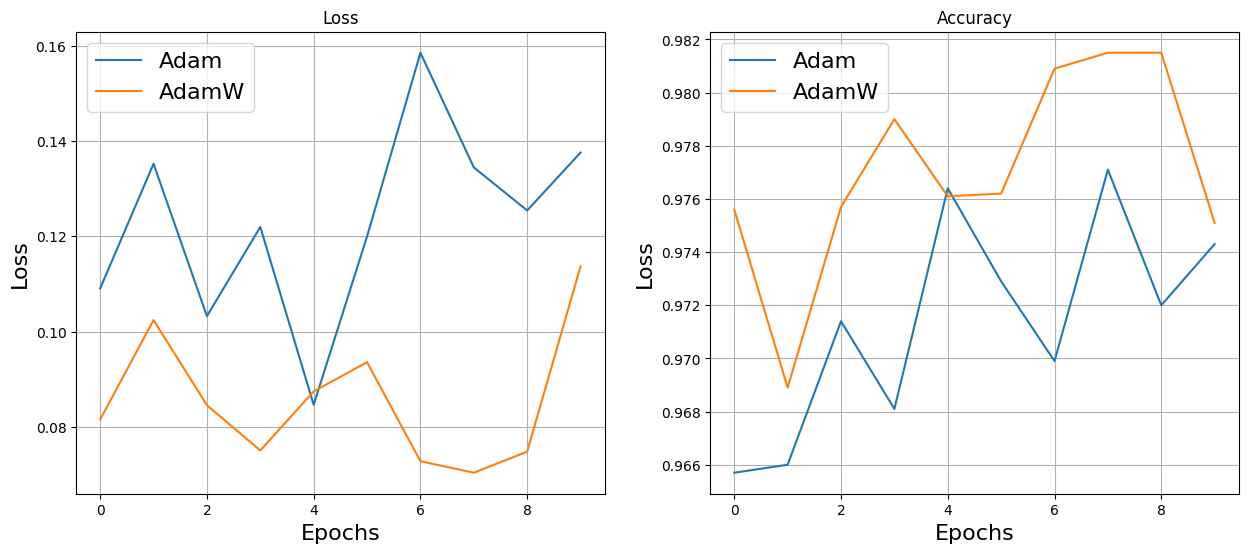

In [30]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Adam')
plt.plot(ts_w, label='AdamW')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Adam')
plt.plot(ts_ac_w, label='AdamW')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Теперь реализуем LinearLR и CosineAnnealingLR

In [32]:
class MyLinearLR:
    def __init__(self, optimizer, start_eta, end_eta, total_iters):
        self.optimizer = optimizer
        self.start_eta = start_eta
        self.end_eta = end_eta
        self.total_iters = total_iters
        self.current_iter = 0

    def step(self):
        ratio = self.current_iter / max(1, self.total_iters)
        new_eta = self.start_eta + ratio * (self.end_eta - self.start_eta)
        
        for param_group in self.optimizer.param_groups:
            param_group['eta'] = new_eta
        
        self.current_iter += 1
        return new_eta


In [35]:
optimizer = Adam(model.parameters())
linear_sched = MyLinearLR(optimizer, start_eta=0.1, end_eta=0.01, total_iters=10)

Epoch 1/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 119.72it/s]


Epoch 1/10 - Train Loss: 0.0760, Train Acc: 0.9820 - Val Loss: 0.0687, Val Acc: 0.9831


Epoch 2/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 132.04it/s]


Epoch 2/10 - Train Loss: 0.0761, Train Acc: 0.9816 - Val Loss: 0.0870, Val Acc: 0.9825


Epoch 3/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 123.87it/s]


Epoch 3/10 - Train Loss: 0.0695, Train Acc: 0.9842 - Val Loss: 0.0745, Val Acc: 0.9825


Epoch 4/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 130.14it/s]


Epoch 4/10 - Train Loss: 0.0685, Train Acc: 0.9844 - Val Loss: 0.0905, Val Acc: 0.9810


Epoch 5/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 115.55it/s]


Epoch 5/10 - Train Loss: 0.0743, Train Acc: 0.9841 - Val Loss: 0.0829, Val Acc: 0.9825


Epoch 6/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 137.07it/s]


Epoch 6/10 - Train Loss: 0.0717, Train Acc: 0.9848 - Val Loss: 0.0894, Val Acc: 0.9835


Epoch 7/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 137.19it/s]


Epoch 7/10 - Train Loss: 0.0668, Train Acc: 0.9856 - Val Loss: 0.1512, Val Acc: 0.9768


Epoch 8/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 129.92it/s]


Epoch 8/10 - Train Loss: 0.0668, Train Acc: 0.9857 - Val Loss: 0.1114, Val Acc: 0.9847


Epoch 9/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 152.08it/s]


Epoch 9/10 - Train Loss: 0.0724, Train Acc: 0.9857 - Val Loss: 0.1799, Val Acc: 0.9785


Epoch 10/10 [Val]: 100%|██████████| 313/313 [00:01<00:00, 163.19it/s]


Epoch 10/10 - Train Loss: 0.0674, Train Acc: 0.9865 - Val Loss: 0.1700, Val Acc: 0.9803


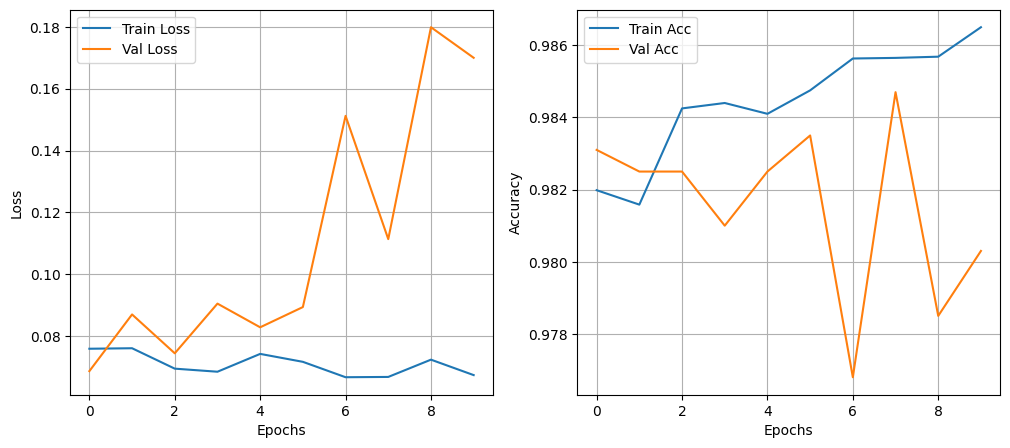

In [36]:
tr_lin_s, ts_lin_s, tr_ac_lin_s, ts_ac_lin_s = train(model, optimizer, train_loader, test_loader)

In [37]:
optimizer = AdamW(model.parameters())
linear_sched = MyLinearLR(optimizer, start_eta=0.1, end_eta=0.01, total_iters=10)

Epoch 1/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 150.19it/s]


Epoch 1/10 - Train Loss: 0.0812, Train Acc: 0.9851 - Val Loss: 0.1259, Val Acc: 0.9773


Epoch 2/10 [Val]: 100%|██████████| 313/313 [00:01<00:00, 170.90it/s]


Epoch 2/10 - Train Loss: 0.0618, Train Acc: 0.9865 - Val Loss: 0.0987, Val Acc: 0.9802


Epoch 3/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 130.84it/s]


Epoch 3/10 - Train Loss: 0.0638, Train Acc: 0.9851 - Val Loss: 0.0783, Val Acc: 0.9832


Epoch 4/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 114.41it/s]


Epoch 4/10 - Train Loss: 0.0602, Train Acc: 0.9860 - Val Loss: 0.0744, Val Acc: 0.9842


Epoch 5/10 [Val]: 100%|██████████| 313/313 [00:01<00:00, 167.20it/s]


Epoch 5/10 - Train Loss: 0.0581, Train Acc: 0.9855 - Val Loss: 0.0909, Val Acc: 0.9796


Epoch 6/10 [Val]: 100%|██████████| 313/313 [00:03<00:00, 97.81it/s] 


Epoch 6/10 - Train Loss: 0.0612, Train Acc: 0.9846 - Val Loss: 0.0837, Val Acc: 0.9804


Epoch 7/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 128.92it/s]


Epoch 7/10 - Train Loss: 0.0623, Train Acc: 0.9843 - Val Loss: 0.0869, Val Acc: 0.9779


Epoch 8/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 115.27it/s]


Epoch 8/10 - Train Loss: 0.0597, Train Acc: 0.9845 - Val Loss: 0.0910, Val Acc: 0.9782


Epoch 9/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 116.55it/s]


Epoch 9/10 - Train Loss: 0.0623, Train Acc: 0.9838 - Val Loss: 0.0822, Val Acc: 0.9825


Epoch 10/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 116.99it/s]


Epoch 10/10 - Train Loss: 0.0651, Train Acc: 0.9836 - Val Loss: 0.0861, Val Acc: 0.9786


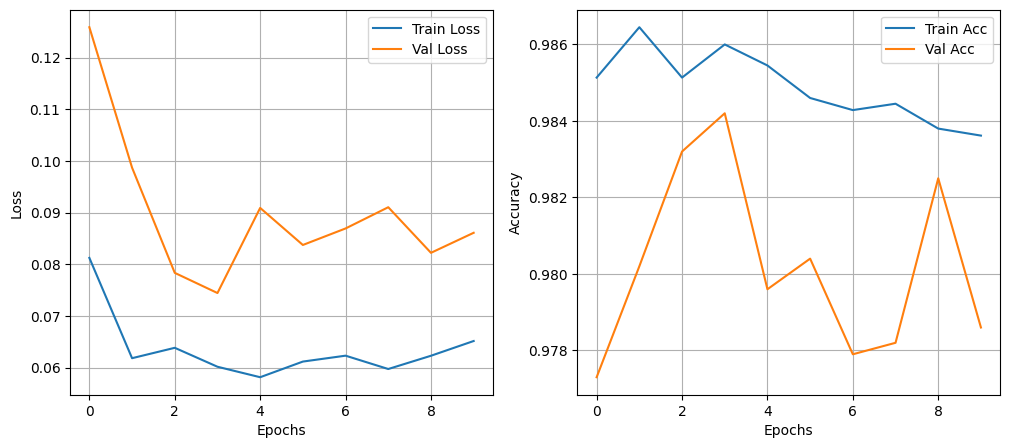

In [38]:
tr_lin_w, ts_lin_w, tr_ac_lin_w, ts_ac_lin_w = train(model, optimizer, train_loader, test_loader)

### Подправлю SGD под реалии моего scheduler
Изменю lr на eta

In [39]:
class SGD(Optimizer):
    def __init__(self, params, eta=1e-2):
        super().__init__(params)
        self.eta = eta

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.eta * p.grad

In [40]:
optimizer = SGD(model.parameters())
linear_sched = MyLinearLR(optimizer, start_eta=0.1, end_eta=0.01, total_iters=10)

Epoch 1/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 141.38it/s]


Epoch 1/10 - Train Loss: 0.0310, Train Acc: 0.9912 - Val Loss: 0.0549, Val Acc: 0.9870


Epoch 2/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 135.69it/s]


Epoch 2/10 - Train Loss: 0.0232, Train Acc: 0.9929 - Val Loss: 0.0520, Val Acc: 0.9877


Epoch 3/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 132.85it/s]


Epoch 3/10 - Train Loss: 0.0210, Train Acc: 0.9937 - Val Loss: 0.0504, Val Acc: 0.9884


Epoch 4/10 [Val]: 100%|██████████| 313/313 [00:03<00:00, 103.58it/s]


Epoch 4/10 - Train Loss: 0.0198, Train Acc: 0.9942 - Val Loss: 0.0500, Val Acc: 0.9882


Epoch 5/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 143.54it/s]


Epoch 5/10 - Train Loss: 0.0188, Train Acc: 0.9945 - Val Loss: 0.0491, Val Acc: 0.9883


Epoch 6/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 142.88it/s]


Epoch 6/10 - Train Loss: 0.0181, Train Acc: 0.9948 - Val Loss: 0.0482, Val Acc: 0.9886


Epoch 7/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 144.59it/s]


Epoch 7/10 - Train Loss: 0.0175, Train Acc: 0.9951 - Val Loss: 0.0485, Val Acc: 0.9879


Epoch 8/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 149.29it/s]


Epoch 8/10 - Train Loss: 0.0169, Train Acc: 0.9950 - Val Loss: 0.0483, Val Acc: 0.9883


Epoch 9/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 145.53it/s]


Epoch 9/10 - Train Loss: 0.0165, Train Acc: 0.9952 - Val Loss: 0.0481, Val Acc: 0.9889


Epoch 10/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 139.94it/s]

Epoch 10/10 - Train Loss: 0.0161, Train Acc: 0.9953 - Val Loss: 0.0472, Val Acc: 0.9892


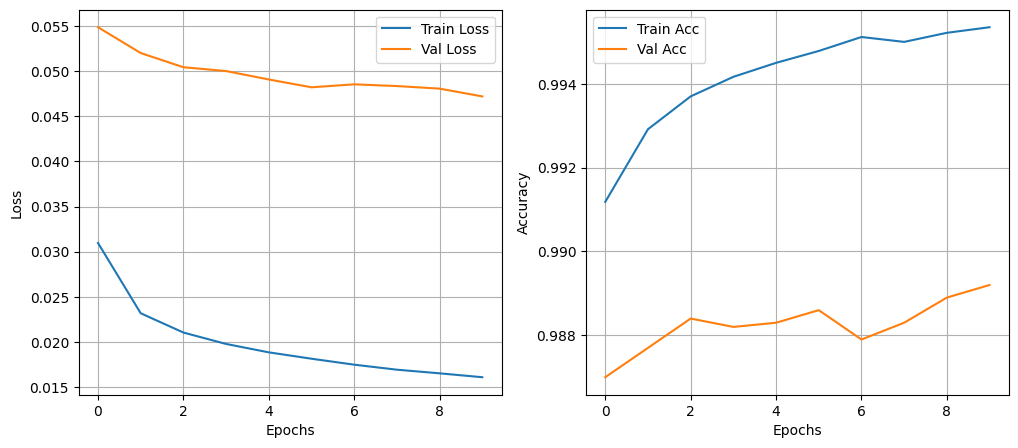

In [41]:
tr_lin_g, ts_lin_g, tr_ac_lin_g, ts_ac_lin_g = train(model, optimizer, train_loader, test_loader)

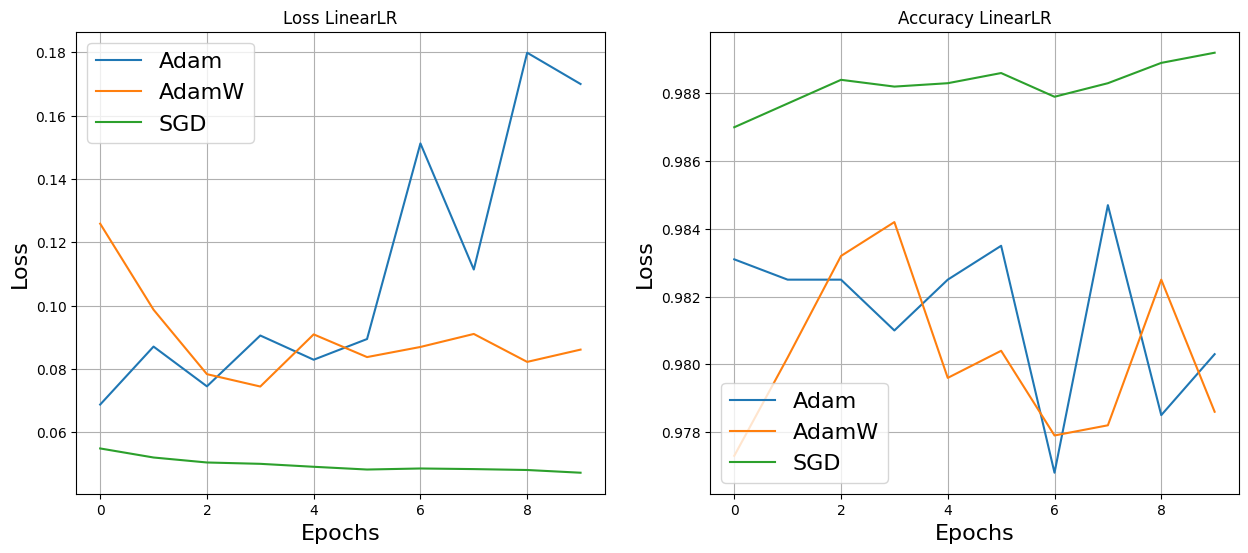

In [42]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title('Loss LinearLR')
plt.plot(ts_lin_s, label='Adam')
plt.plot(ts_lin_w, label='AdamW')
plt.plot(ts_lin_g, label='SGD')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy LinearLR')
plt.plot(ts_ac_lin_s, label='Adam')
plt.plot(ts_ac_lin_w, label='AdamW')
plt.plot(ts_ac_lin_g, label='SGD')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

In [47]:
class MyCosineAnnealingLR:
    def __init__(self, optimizer, end_eta, start_eta, total_iters):
        self.optimizer = optimizer
        self.end_eta = end_eta
        self.start_eta = start_eta
        self.total_iters = total_iters
        self.current_iter = 0

    def step(self):
        cos_inner = torch.pi * self.current_iter / self.total_iters
        new_eta = self.start_eta + 0.5 * (self.end_eta - self.start_eta) * (1 + torch.cos(cos_inner))
        
        for param_group in self.optimizer.param_groups:
            param_group['eta'] = new_eta

        self.current_iter += 1
        return new_eta

In [48]:
optimizer = Adam(model.parameters())
linear_sched = MyCosineAnnealingLR(optimizer, start_eta=0.1, end_eta=0.01, total_iters=10)

Epoch 1/10 [Val]: 100%|██████████| 313/313 [00:03<00:00, 91.85it/s] 


Epoch 1/10 - Train Loss: 0.0627, Train Acc: 0.9850 - Val Loss: 0.0860, Val Acc: 0.9805


Epoch 2/10 [Val]: 100%|██████████| 313/313 [00:03<00:00, 90.62it/s] 


Epoch 2/10 - Train Loss: 0.0696, Train Acc: 0.9837 - Val Loss: 0.1126, Val Acc: 0.9762


Epoch 3/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 126.48it/s]


Epoch 3/10 - Train Loss: 0.0683, Train Acc: 0.9841 - Val Loss: 0.0946, Val Acc: 0.9795


Epoch 4/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 105.61it/s]


Epoch 4/10 - Train Loss: 0.0734, Train Acc: 0.9842 - Val Loss: 0.0904, Val Acc: 0.9789


Epoch 5/10 [Val]: 100%|██████████| 313/313 [00:01<00:00, 158.97it/s]


Epoch 5/10 - Train Loss: 0.0608, Train Acc: 0.9865 - Val Loss: 0.1180, Val Acc: 0.9811


Epoch 6/10 [Val]: 100%|██████████| 313/313 [00:03<00:00, 79.16it/s]


Epoch 6/10 - Train Loss: 0.0690, Train Acc: 0.9859 - Val Loss: 0.1306, Val Acc: 0.9817


Epoch 7/10 [Val]: 100%|██████████| 313/313 [00:04<00:00, 75.35it/s]


Epoch 7/10 - Train Loss: 0.0644, Train Acc: 0.9864 - Val Loss: 0.1292, Val Acc: 0.9791


Epoch 8/10 [Val]: 100%|██████████| 313/313 [00:06<00:00, 49.06it/s]


Epoch 8/10 - Train Loss: 0.0660, Train Acc: 0.9862 - Val Loss: 0.1531, Val Acc: 0.9795


Epoch 9/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 124.29it/s]


Epoch 9/10 - Train Loss: 0.0769, Train Acc: 0.9854 - Val Loss: 0.1246, Val Acc: 0.9791


Epoch 10/10 [Val]: 100%|██████████| 313/313 [00:05<00:00, 55.91it/s]


Epoch 10/10 - Train Loss: 0.0660, Train Acc: 0.9869 - Val Loss: 0.1729, Val Acc: 0.9825


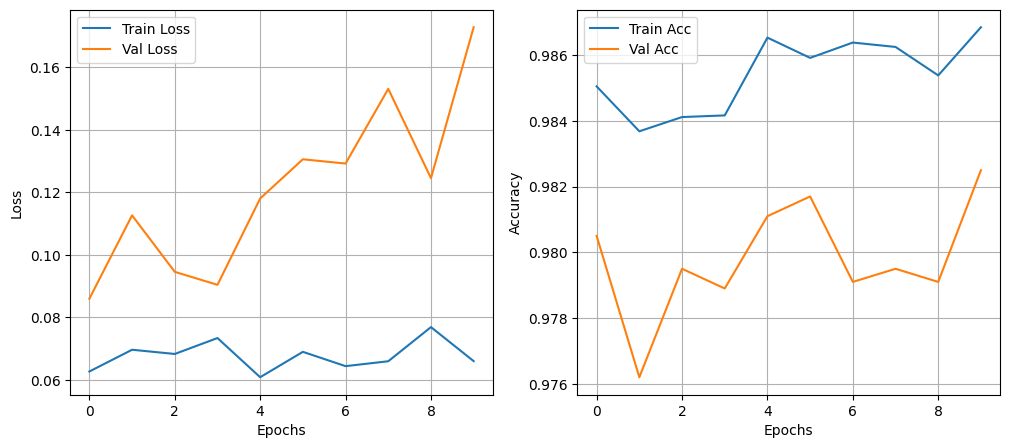

In [49]:
tr_cos_s, ts_cos_s, tr_ac_cos_s, ts_ac_cos_s = train(model, optimizer, train_loader, test_loader)

In [50]:
optimizer = AdamW(model.parameters())
linear_sched = MyCosineAnnealingLR(optimizer, start_eta=0.1, end_eta=0.01, total_iters=10)

Epoch 1/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 138.09it/s]


Epoch 1/10 - Train Loss: 0.0800, Train Acc: 0.9858 - Val Loss: 0.1506, Val Acc: 0.9799


Epoch 2/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 136.49it/s]


Epoch 2/10 - Train Loss: 0.0674, Train Acc: 0.9857 - Val Loss: 0.1203, Val Acc: 0.9754


Epoch 3/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 138.98it/s]


Epoch 3/10 - Train Loss: 0.0587, Train Acc: 0.9865 - Val Loss: 0.1130, Val Acc: 0.9786


Epoch 4/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 116.39it/s]


Epoch 4/10 - Train Loss: 0.0586, Train Acc: 0.9856 - Val Loss: 0.0787, Val Acc: 0.9819


Epoch 5/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 145.44it/s]


Epoch 5/10 - Train Loss: 0.0581, Train Acc: 0.9859 - Val Loss: 0.0668, Val Acc: 0.9834


Epoch 6/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 143.37it/s]


Epoch 6/10 - Train Loss: 0.0592, Train Acc: 0.9853 - Val Loss: 0.0818, Val Acc: 0.9813


Epoch 7/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 141.40it/s]


Epoch 7/10 - Train Loss: 0.0619, Train Acc: 0.9839 - Val Loss: 0.1258, Val Acc: 0.9729


Epoch 8/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 140.11it/s]


Epoch 8/10 - Train Loss: 0.0597, Train Acc: 0.9852 - Val Loss: 0.1274, Val Acc: 0.9765


Epoch 9/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 147.70it/s]


Epoch 9/10 - Train Loss: 0.0617, Train Acc: 0.9840 - Val Loss: 0.1279, Val Acc: 0.9711


Epoch 10/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 128.28it/s]


Epoch 10/10 - Train Loss: 0.0628, Train Acc: 0.9835 - Val Loss: 0.0764, Val Acc: 0.9804


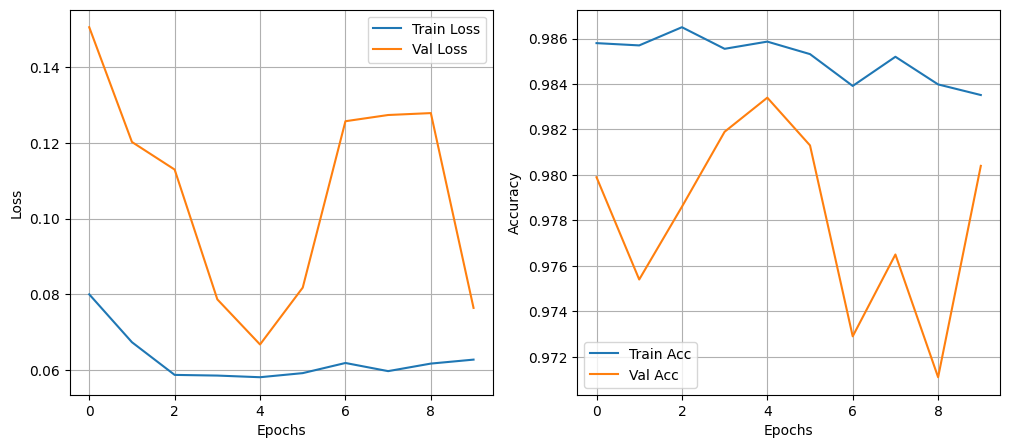

In [51]:
tr_cos_w, ts_cos_w, tr_ac_cos_w, ts_ac_cos_w = train(model, optimizer, train_loader, test_loader)

In [52]:
optimizer = SGD(model.parameters())
linear_sched = MyCosineAnnealingLR(optimizer, start_eta=0.1, end_eta=0.01, total_iters=10)

Epoch 1/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 131.60it/s]


Epoch 1/10 - Train Loss: 0.0331, Train Acc: 0.9907 - Val Loss: 0.0507, Val Acc: 0.9856


Epoch 2/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 143.92it/s]


Epoch 2/10 - Train Loss: 0.0251, Train Acc: 0.9929 - Val Loss: 0.0459, Val Acc: 0.9869


Epoch 3/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 133.37it/s]


Epoch 3/10 - Train Loss: 0.0224, Train Acc: 0.9936 - Val Loss: 0.0439, Val Acc: 0.9882


Epoch 4/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 120.87it/s]


Epoch 4/10 - Train Loss: 0.0209, Train Acc: 0.9938 - Val Loss: 0.0427, Val Acc: 0.9881


Epoch 5/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 153.31it/s]


Epoch 5/10 - Train Loss: 0.0199, Train Acc: 0.9941 - Val Loss: 0.0415, Val Acc: 0.9886


Epoch 6/10 [Val]: 100%|██████████| 313/313 [00:01<00:00, 166.35it/s]


Epoch 6/10 - Train Loss: 0.0191, Train Acc: 0.9944 - Val Loss: 0.0411, Val Acc: 0.9886


Epoch 7/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 144.74it/s]


Epoch 7/10 - Train Loss: 0.0184, Train Acc: 0.9945 - Val Loss: 0.0409, Val Acc: 0.9887


Epoch 8/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 151.46it/s]


Epoch 8/10 - Train Loss: 0.0178, Train Acc: 0.9946 - Val Loss: 0.0406, Val Acc: 0.9889


Epoch 9/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 144.97it/s]


Epoch 9/10 - Train Loss: 0.0173, Train Acc: 0.9949 - Val Loss: 0.0406, Val Acc: 0.9889


Epoch 10/10 [Val]: 100%|██████████| 313/313 [00:02<00:00, 141.54it/s]

Epoch 10/10 - Train Loss: 0.0169, Train Acc: 0.9950 - Val Loss: 0.0405, Val Acc: 0.9891


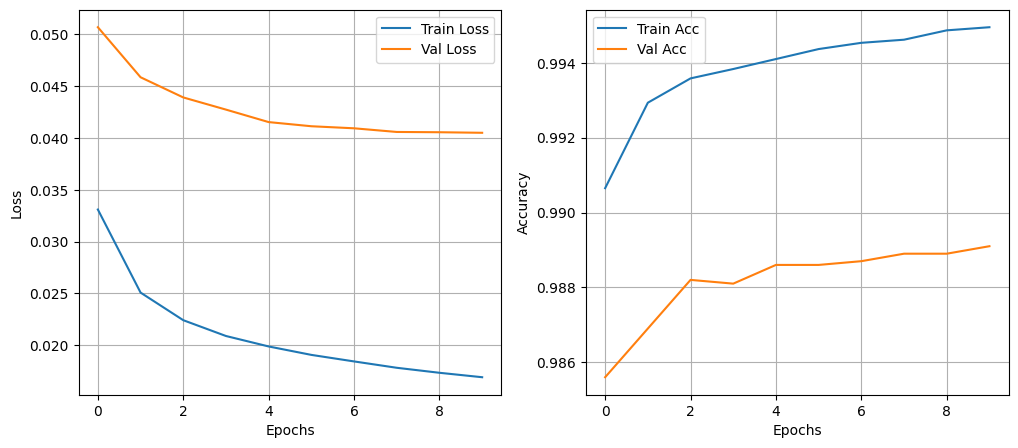

In [53]:
tr_cos_g, ts_cos_g, tr_ac_cos_g, ts_ac_cos_g = train(model, optimizer, train_loader, test_loader)

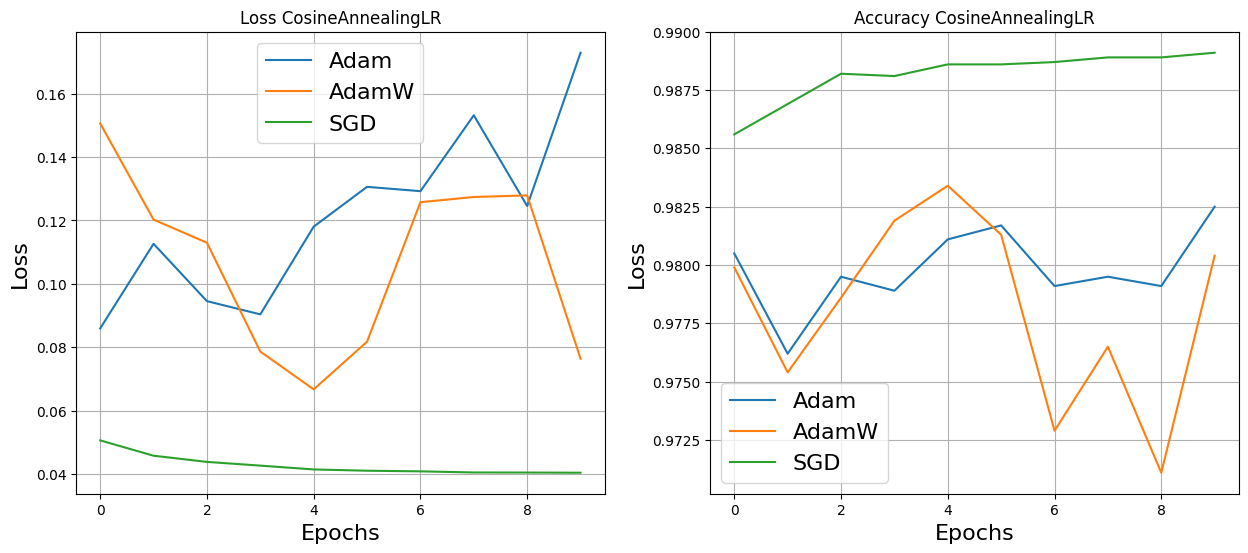

In [54]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title('Loss CosineAnnealingLR')
plt.plot(ts_cos_s, label='Adam')
plt.plot(ts_cos_w, label='AdamW')
plt.plot(ts_cos_g, label='SGD')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy CosineAnnealingLR')
plt.plot(ts_ac_cos_s, label='Adam')
plt.plot(ts_ac_cos_w, label='AdamW')
plt.plot(ts_ac_cos_g, label='SGD')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

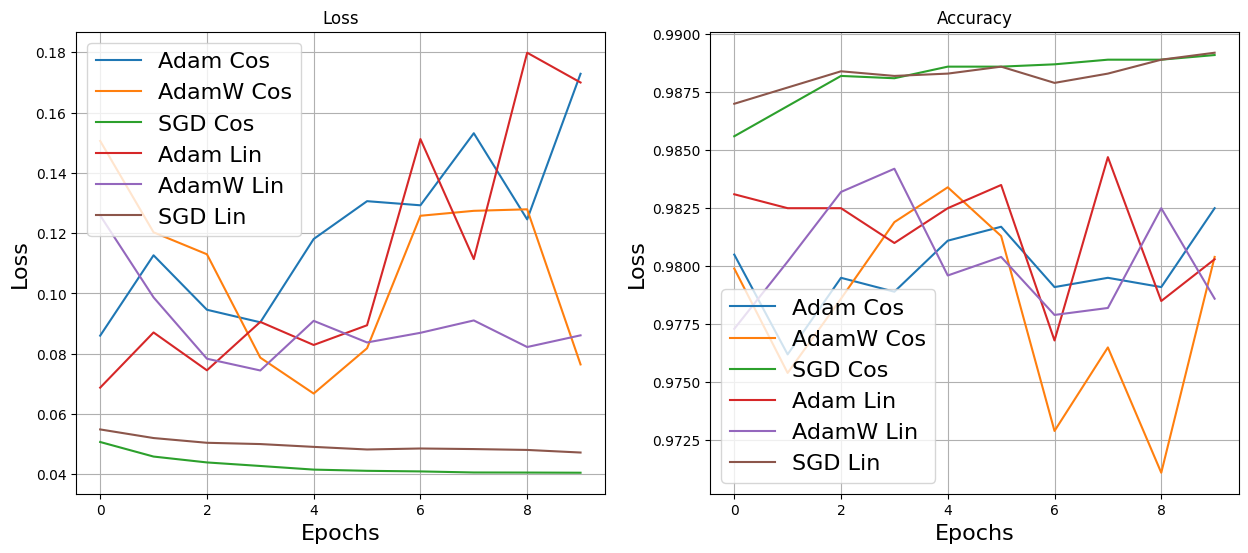

In [55]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_cos_s, label='Adam Cos')
plt.plot(ts_cos_w, label='AdamW Cos')
plt.plot(ts_cos_g, label='SGD Cos')
plt.plot(ts_lin_s, label='Adam Lin')
plt.plot(ts_lin_w, label='AdamW Lin')
plt.plot(ts_lin_g, label='SGD Lin')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_cos_s, label='Adam Cos')
plt.plot(ts_ac_cos_w, label='AdamW Cos')
plt.plot(ts_ac_cos_g, label='SGD Cos')
plt.plot(ts_ac_lin_s, label='Adam Lin')
plt.plot(ts_ac_lin_w, label='AdamW Lin')
plt.plot(ts_ac_lin_g, label='SGD Lin')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Делаем вывод, где-то я очень сильно напортачил в реализации Adam и AdamW
Возможно стоило побольше поиграться с гиперпараметрами

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

- Your text here

Здесь вы можете оставить комментарии по лекции или семинару:

- Your text here